# Homework 6 Deep Learning - Rishabh Bassi #

Check out the Jupyter notebook for Chapter 10 at https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter10_dl-for-timeseries.ipynb. It has tried 7 methods for the temperature prediction problem: Try 1 (A common-sense, non-machine learning baseline method), Try 2 (A fully connected neural network), Try 3 (1-d convolutional neural networks), Try 4 (Recurrent neural network), Try 5 (LSTM with recurrent dropout), Try 6 (stacking RNN layers), Try 7 (Bidirectional RNN).

Your task: use the above 7 methods to predict the temperature in 48 hours (instead of 24 hours). In the Jupyter notebook, include your code as well as the performance of the 7 methods.

Data Preprocessing

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-10-31 04:06:39--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.87.110, 52.216.76.62, 16.182.99.88, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.87.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  5.95MB/s    in 2.2s    

2023-10-31 04:06:42 (5.95 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [ ]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [ ]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

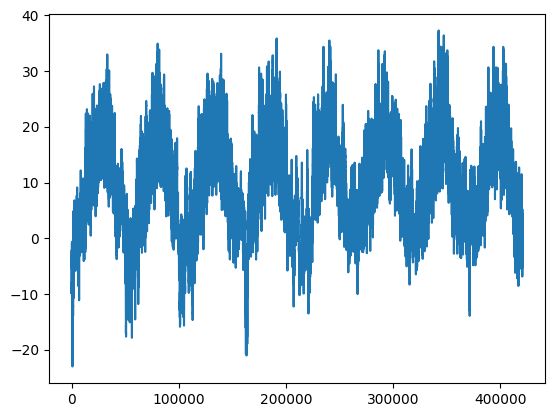

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

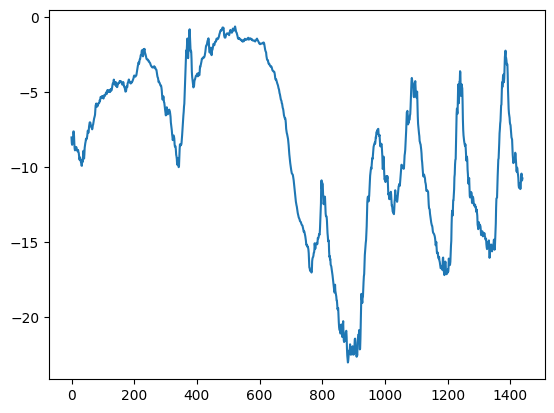

In [ ]:
plt.plot(range(1440), temperature[:1440])

In [ ]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [ ]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [ ]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [ ]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 48 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [ ]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


Below are the models run output one by one.

## 1) A common-sense, non-machine-learning baseline



In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 3.21
Test MAE: 3.47


## 2) A fully connected neural network

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.h5",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.h5")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 54s 60ms/step - loss: 19.5359 - mae: 3.4731 - val_loss: 20.1784 - val_mae: 3.5938
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


819/819 [==============================] - 48s 58ms/step - loss: 14.7255 - mae: 3.0492 - val_loss: 16.6439 - val_mae: 3.2515
Epoch 3/10
819/819 [==============================] - 43s 52ms/step - loss: 13.5911 - mae: 2.9272 - val_loss: 15.9522 - val_mae: 3.1674
Epoch 4/10
819/819 [==============================] - 45s 55ms/step - loss: 12.8702 - mae: 2.8474 - val_loss: 17.7976 - val_mae: 3.3286
Epoch 5/10
819/819 [==============================] - 38s 47ms/step - loss: 12.3181 - mae: 2.7847 - val_loss: 18.1970 - val_mae: 3.3630
Epoch 6/10
819/819 [==============================] - 48s 59ms/step - loss: 11.9469 - mae: 2.7429 - val_loss: 18.8730 - val_mae: 3.4623
Epoch 7/10
819/819 [==============================] - 47s 57ms/step - loss: 11.6436 - mae: 2.7081 - val_loss: 18.5850 - val_mae: 3.4091
Epoch 8/10
819/819 [==============================] - 48s 58ms/step - loss: 11.4132 - mae: 2.6792 - val_loss: 17.7929 - val_mae: 3.3420
Epoch 9/10
819/819 [==============================] - 48s 5

In [ ]:
print(f"A fully connected neural network-Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

404/404 [==============================] - 13s 31ms/step - loss: 17.3679 - mae: 3.3213
A fully connected neural network-Test MAE: 3.32


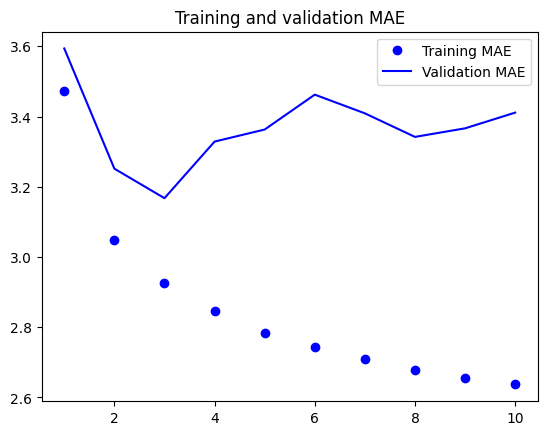

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## 3) 1-d convolutional neural networks

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.h5",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.h5")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 45s 49ms/step - loss: 25.5809 - mae: 3.9917 - val_loss: 20.0796 - val_mae: 3.5653
Epoch 2/10
819/819 [==============================] - 49s 59ms/step - loss: 18.4137 - mae: 3.4313 - val_loss: 19.6011 - val_mae: 3.5103
Epoch 3/10
819/819 [==============================] - 49s 59ms/step - loss: 15.7963 - mae: 3.1663 - val_loss: 19.6040 - val_mae: 3.4820
Epoch 4/10
819/819 [==============================] - 48s 58ms/step - loss: 14.6973 - mae: 3.0469 - val_loss: 22.0388 - val_mae: 3.6752
Epoch 5/10
819/819 [==============================] - 49s 59ms/step - loss: 13.9658 - mae: 2.9652 - val_loss: 20.0874 - val_mae: 3.5281
Epoch 6/10
819/819 [==============================] - 50s 60ms/step - loss: 13.3293 - mae: 2.8949 - val_loss: 20.8953 - val_mae: 3.5909
Epoch 7/10
819/819 [==============================] - 41s 49ms/step - loss: 12.8120 - mae: 2.8387 - val_loss: 20.8446 - val_mae: 3.5830
Epoch 8/10
819/819 [============================

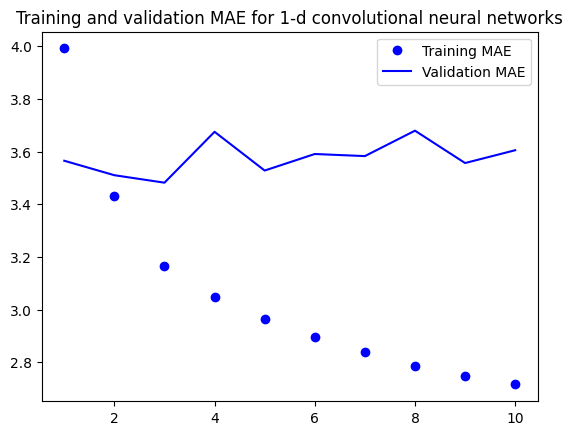

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE for 1-d convolutional neural networks")
plt.legend()
plt.show()

In [ ]:
print(f"1-d convolutional neural networks- Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

404/404 [==============================] - 14s 33ms/step - loss: 21.8858 - mae: 3.7149
1-d convolutional neural networks- Test MAE: 3.71


## 4) Recurrent neural network

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.h5",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.h5")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 48s 53ms/step - loss: 48.0585 - mae: 5.2030 - val_loss: 18.1154 - val_mae: 3.3034
Epoch 2/10
819/819 [==============================] - 50s 61ms/step - loss: 16.6930 - mae: 3.2065 - val_loss: 15.5425 - val_mae: 3.0850
Epoch 3/10
819/819 [==============================] - 42s 52ms/step - loss: 15.3073 - mae: 3.0660 - val_loss: 15.8539 - val_mae: 3.1187
Epoch 4/10
819/819 [==============================] - 42s 51ms/step - loss: 14.6972 - mae: 3.0010 - val_loss: 15.8351 - val_mae: 3.1034
Epoch 5/10
819/819 [==============================] - 51s 62ms/step - loss: 14.3082 - mae: 2.9613 - val_loss: 16.0250 - val_mae: 3.1270
Epoch 6/10
819/819 [==============================] - 41s 50ms/step - loss: 13.9134 - mae: 2.9187 - val_loss: 16.0696 - val_mae: 3.1188
Epoch 7/10
819/819 [==============================] - 42s 52ms/step - loss: 13.5952 - mae: 2.8839 - val_loss: 16.3449 - val_mae: 3.1523
Epoch 8/10
819/819 [============================

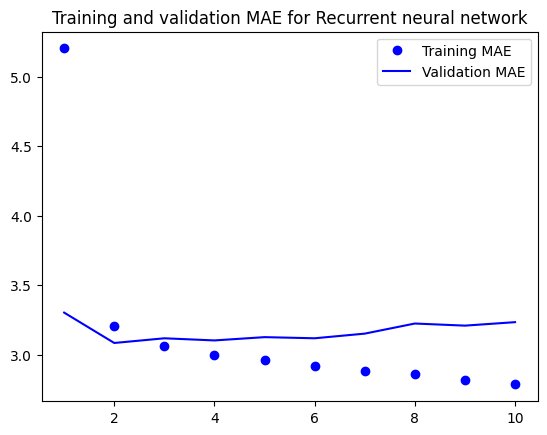

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE for Recurrent neural network")
plt.legend()
plt.show()

In [ ]:
print(f"Recurrent neural network- Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

404/404 [==============================] - 14s 33ms/step - loss: 19.4049 - mae: 3.4578
Recurrent neural network- Test MAE: 3.46


In [ ]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

In [ ]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


In [ ]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## 5) LSTM with recurrent dropout


In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.h5",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 372s 449ms/step - loss: 31.5275 - mae: 4.2490 - val_loss: 17.3361 - val_mae: 3.2363
Epoch 2/50
819/819 [==============================] - 384s 469ms/step - loss: 19.5227 - mae: 3.4619 - val_loss: 16.0865 - val_mae: 3.1304
Epoch 3/50
819/819 [==============================] - 371s 452ms/step - loss: 18.1765 - mae: 3.3401 - val_loss: 16.5710 - val_mae: 3.1784
Epoch 4/50
819/819 [==============================] - 372s 455ms/step - loss: 17.2745 - mae: 3.2497 - val_loss: 16.0750 - val_mae: 3.1451
Epoch 5/50
819/819 [==============================] - 362s 442ms/step - loss: 16.6429 - mae: 3.1882 - val_loss: 16.4744 - val_mae: 3.1772
Epoch 6/50
819/819 [==============================] - 368s 450ms/step - loss: 15.9857 - mae: 3.1201 - val_loss: 16.4615 - val_mae: 3.1914
Epoch 7/50
819/819 [==============================] - 367s 447ms/step - loss: 15.5523 - mae: 3.0743 - val_loss: 17.2193 - val_mae: 3.2213
Epoch 8/50
819/819 [==============

In [ ]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE for LSTM with recurrent dropout ")
plt.legend()
plt.show()

In [ ]:
print(f"LSTM with recurrent dropout- Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

## 6) Stacking RNN layers

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.h5",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.h5")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE for stacking RNN layers")
plt.legend()
plt.show()

In [ ]:
print(f"stacking RNN layers- Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

## 7) Bidirectional RNN

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE for Bidirectional RNN ")
plt.legend()
plt.show()

In [ ]:
print(f"Bidirectional RNN - Test MAE: {model.evaluate(test_dataset)[1]:.2f}")